In [3]:
from fbprophet import Prophet

In [4]:
# from pycaret.regression import *

In [5]:
#!pip install pycaret

In [6]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import numpy as np

In [7]:
# plotting one time series
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Value', dpi=100):
    plt.figure(figsize=(16,5), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()

In [ ]:
def wmape(y_true, y_pred):
  errors = y_true - y_pred
  wmape_val = 100*np.round(np.sum(abs(errors))/np.sum(y_true),6)
  return (wmape_val, errors)

In [ ]:
class TimeSeries(object):
  def __init__(self, time_col, df):
    self._time_col = time_col
    self._values = df
    self._product_id = df.product_id.iloc[0]

    self._time_indexed = pd.to_datetime(df[time_col])

    self.init_ts()
    self._how_many_nonzero_initaly()
  
  def init_ts(self):
    self._values.index = self._time_indexed
    self._ts = self._values.asfreq('W-Mon').sort_index(ascending = True).fillna(0)

  def _how_many_nonzero_initaly(self):
    self._non_zero_weeks = self._values.shape[0]
    self._non_zero_share = 100*round(self._non_zero_weeks/self._ts.shape[0],4)

  def plot_time_series(self, col_to_plot):
    self._ts[[col_to_plot]].plot(marker='o', title = f"product_id = {self._product_id}")

In [8]:
sales_data = pd.read_csv("sales.csv",   header = 0, sep = ";")
categories = pd.read_csv("categories.csv",   header = 0, sep = ";")

traffic = pd.read_csv("traffic.csv",   header = 0, sep = ";")
traffic["DateTime"] = traffic['week_starting_date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))

In [9]:
sales_data.shape

(105781, 3)

In [ ]:
sales_data.isnull().any()

week_starting_date    False
product_id            False
sales                 False
dtype: bool

In [ ]:
categories.isnull().any()

product_id     False
category_id    False
dtype: bool

In [ ]:
traffic.isnull().any()

week_starting_date    False
product_id            False
traffic               False
DateTime              False
dtype: bool

In [ ]:
sales_data["product_id"].nunique()

2926

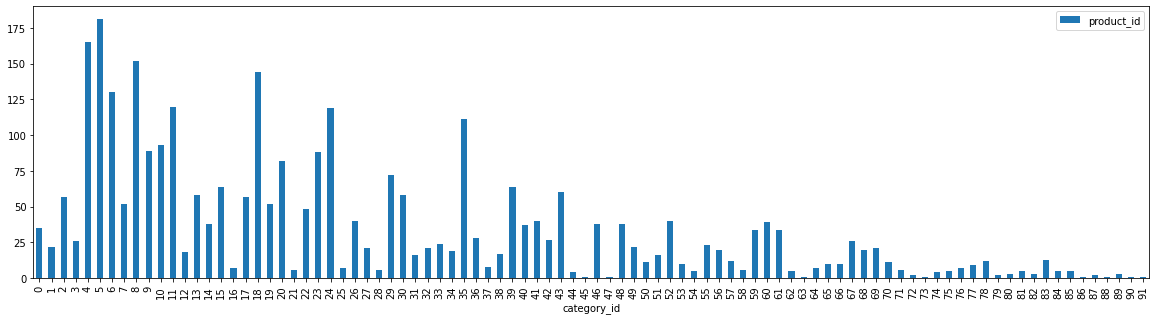

In [ ]:
categories.groupby("category_id", as_index = False).count().plot.bar(x = "category_id", y = "product_id", figsize=(20,5))

In [10]:
# basic sales dataset preparation

sales_data['DateTime'] = sales_data['week_starting_date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
sales_data['Week_numb'] = sales_data['DateTime'].apply(lambda x: x.strftime("%V"))
sales_data['YW'] = sales_data['DateTime'].apply(lambda x: x.strftime("%Y%V"))
sales_data['Month'] = sales_data['DateTime'].apply(lambda x: x.month)
weekly_sales = sales_data.groupby(["product_id", "DateTime", "Week_numb", "YW","Month", "week_starting_date"], as_index=False).agg({'sales':'sum'})

In [11]:
weekly_sales.shape

(105781, 7)

In [12]:
# join product category and traffic
full_sales_dataset = weekly_sales\
.merge(categories, on=["product_id"],  how = 'left')\
.merge(traffic, on=["week_starting_date", "product_id"],  how = 'left')

In [13]:
full_sales_dataset.shape

(105781, 10)

In [ ]:
# prod 5 prod 4
ex = TimeSeries("DateTime_x" ,full_sales_dataset.loc[full_sales_dataset['product_id'] == 4])

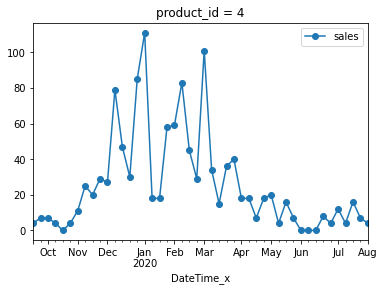

In [ ]:
ex.plot_time_series("sales")

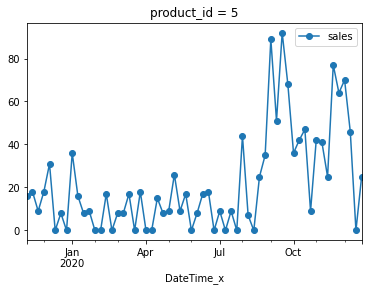

In [ ]:
# prod 5 prod 4
ex = TimeSeries("DateTime_x" ,full_sales_dataset.loc[full_sales_dataset['product_id'] == 5])
ex.plot_time_series("sales")

In [ ]:
full_sales_dataset[["product_id", "DateTime_x", "sales"]].pivot(index = "product_id", columns = "DateTime_x", values = "sales").fillna(0)

DateTime_x,2019-01-07,2019-01-14,2019-01-21,2019-01-28,2019-02-04,2019-02-11,2019-02-18,2019-02-25,2019-03-04,2019-03-11,2019-03-18,2019-03-25,2019-04-01,2019-04-08,2019-04-15,2019-04-22,2019-04-29,2019-05-06,2019-05-13,2019-05-20,2019-05-27,2019-06-03,2019-06-10,2019-06-17,2019-06-24,2019-07-01,2019-07-08,2019-07-15,2019-07-22,2019-07-29,2019-08-05,2019-08-12,2019-08-19,2019-08-26,2019-09-02,2019-09-09,2019-09-16,2019-09-23,2019-09-30,2019-10-07,...,2020-03-30,2020-04-06,2020-04-13,2020-04-20,2020-04-27,2020-05-04,2020-05-11,2020-05-18,2020-05-25,2020-06-01,2020-06-08,2020-06-15,2020-06-22,2020-06-29,2020-07-06,2020-07-13,2020-07-20,2020-07-27,2020-08-03,2020-08-10,2020-08-17,2020-08-24,2020-08-31,2020-09-07,2020-09-14,2020-09-21,2020-09-28,2020-10-05,2020-10-12,2020-10-19,2020-10-26,2020-11-02,2020-11-09,2020-11-16,2020-11-23,2020-11-30,2020-12-07,2020-12-14,2020-12-21,2020-12-28
product_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,4.0,4.0,14.0,4.0,1.0,10.0,9.0,3.0,4.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2166.0,784.0,764.0,835.0,416.0,692.0,435.0,357.0,376.0,187.0,127.0,110.0,94.0,107.0,134.0,86.0,97.0,40.0,61.0,26.0,79.0,98.0,116.0,200.0,95.0,165.0,124.0,137.0,232.0,391.0,171.0,291.0,509.0,531.0,1045.0,913.0,1310.0,1115.0,0.0,6.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,3.0,3.0,0.0,0.0,0.0,...,14.0,0.0,10.0,23.0,10.0,11.0,13.0,7.0,6.0,16.0,6.0,0.0,10.0,16.0,13.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,0.0,4.0,4.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,7.0,7.0,...,40.0,18.0,18.0,7.0,18.0,20.0,4.0,16.0,7.0,0.0,0.0,0.0,8.0,4.0,12.0,4.0,16.0,7.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.0,0.0,0.0,15.0,8.0,9.0,26.0,9.0,17.0,0.0,8.0,17.0,18.0,0.0,9.0,0.0,9.0,0.0,44.0,7.0,0.0,25.0,35.0,89.0,51.0,92.0,68.0,36.0,42.0,47.0,9.0,42.0,41.0,25.0,77.0,64.0,70.0,46.0,0.0,25.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3131,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,6.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,12.0,6.0,12.0,0.0,0.0,0.0
3132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.0,5.0,6.0,0.0,0.0,5.0,11.0,6.0,11.0,10.0,5.0,0.0,5.0,6.0,6.0,11.0,16.0,21.0,27.0,6.0,28.0,6.0,6.0,11.0
3133,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,5

#Very first EDA

How much observations do we have if we expand a horizon with weekly frequency from start to end for each product. Therefore we can have a very first split on low- and high- frequency selling items.

In [ ]:
#how much observations do we have if we expand a horizon with weekly frequency from start to end for each product. Therefore we can have a very first split on low- and high- frequency selling items.

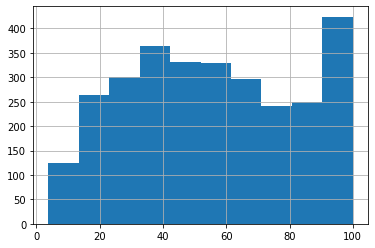

In [14]:
# here we have original dataset
full_sales_dataset_indexed = full_sales_dataset.set_index(["product_id", "DateTime_x"])

# here we expand all the gaps in between
full_sales_dataset_indexed_expanded = full_sales_dataset_indexed.groupby(level=0).apply(lambda x: x.reset_index(level=0, drop=True).asfreq("W-Mon").fillna(0))

# how many obsevations do we have per each product_id
original_count = full_sales_dataset_indexed[["sales"]].groupby(level=0).count().rename(columns={'sales':'weeks_original'})

# how much do we have when we expand the gaps in between
expanded_count = full_sales_dataset_indexed_expanded[["sales"]].groupby(level=0).count().rename(columns={'sales':'weeks_expanded'})

result = pd.concat([expanded_count, original_count], axis=1, join="outer").pipe(lambda x: x.assign(nonzero_obs_share = 100*round(x.weeks_original/x.weeks_expanded,4)))

result.nonzero_obs_share.hist()

In [15]:
full_sales_dataset_indexed.shape

(105781, 8)

In [16]:
full_sales_dataset_indexed_expanded.shape

(203730, 8)

In [ ]:
result.sort_values(by = ["nonzero_obs_share"])

,weeks_expanded,weeks_original,nonzero_obs_share
product_id,,,
2537,53,2,3.77
866,76,3,3.95
1636,74,3,4.05
1303,74,3,4.05
1346,89,4,4.49
...,...,...,...
2658,46,46,100.00
1308,35,35,100.00
2894,1,1,100.00


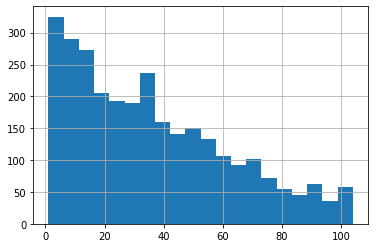

In [ ]:
result.weeks_original.hist(bins = 20)

In [ ]:
# average time distance per product_id between non-zero sales
full_sales_dataset_indexed.loc[[1322]].index

MultiIndex([(1322, '2020-10-26'),
            (1322, '2020-11-02'),
            (1322, '2020-11-09'),
            (1322, '2020-11-16'),
            (1322, '2020-11-23'),
            (1322, '2020-11-30'),
            (1322, '2020-12-07'),
            (1322, '2020-12-14'),
            (1322, '2020-12-21')],
           names=['product_id', 'DateTime_x'])

In [ ]:
# average time distance per product_id between non-zero sales
#full_sales_dataset_indexed[full_sales_dataset_indexed.index.get_level_values(1) == '2020-07-06']

In [ ]:
#xxx = full_sales_dataset_indexed[full_sales_dataset_indexed.index.get_level_values(0) == 1].index.get_level_values(1).to_series().diff().astype('timedelta64[W]').values

In [ ]:
def time_interval_between_obs(ts):
  series_with_time = ts.index.get_level_values(1).to_series().diff().astype('timedelta64[W]').values
  all_obs = len(series_with_time)-1
  counts = np.array(np.unique(series_with_time,  return_counts = True))
  argmax_counts_freq = np.argmax(counts[1])
  max_freq_value = counts[0][argmax_counts_freq]
  return (ts.index.get_level_values(0)[0], all_obs, max_freq_value, round(counts[1][argmax_counts_freq]/all_obs,4))

In [ ]:
time_interval_between_obs(full_sales_dataset_indexed[full_sales_dataset_indexed.index.get_level_values(0) == 3135])

(3135, 10, 1.0, 0.9)

In [ ]:
full_sales_dataset_indexed_copy = full_sales_dataset_indexed.copy()

In [ ]:
full_sales_dataset_indexed_copy.index.get_level_values(0)

Int64Index([   1,    1,    1,    1,    1,    1,    1,    1,    1,    1,
            ...
            3135, 3135, 3135, 3135, 3135, 3135, 3135, 3135, 3135, 3135],
           dtype='int64', name='product_id', length=105781)

In [ ]:
weeks_frequency = pd.DataFrame(list(full_sales_dataset_indexed.groupby(level=0).apply(lambda x: time_interval_between_obs(x)))
, columns =['product_id', 'all_obs' ,'freq_in_weeks_dominating', 'perc'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning:

divide by zero encountered in double_scalars



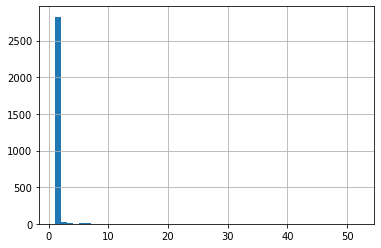

In [ ]:
weeks_frequency.freq_in_weeks_dominating.hist(bins = 50)

In [ ]:
# full_sales_dataset_indexed_copy["freq_"] = list(full_sales_dataset_indexed.groupby(level=0).apply(lambda x: time_interval_between_obs(x)))

In [ ]:
ex = TimeSeries("DateTime_x" ,full_sales_dataset.loc[full_sales_dataset['product_id'] == 5])

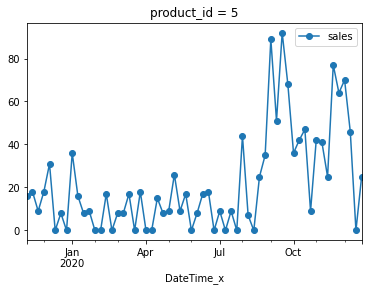

In [ ]:
ex.plot_time_series("sales")

# Working on forecast methods

In [ ]:
# Import libraries
from statsmodels.tsa.statespace.varmax import VARMAX
from random import random
# Generate a sample dataset with correlated variables
data = list()
for i in range(100):
    v1 = i+ random()
    v2 = v1 + random()
    row = [v1, v2]
    data.append(row)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
data

[[0.81190329282059, 1.557895379404356],
 [1.574068675170272, 1.6505690542459368],
 [2.417364722052132, 3.0013574358092225],
 [3.9882269931772147, 4.138470641989251],
 [4.429054695871497, 4.9243530278967285],
 [5.571269214222644, 6.228090785643901],
 [6.530677741404871, 7.18182915714228],
 [7.015444599003242, 7.210704173744487],
 [8.218736404666588, 8.417043449770444],
 [9.675856299164897, 9.874471595577306],
 [10.137622617563212, 10.839384004784634],
 [11.749667535439713, 12.141032099403015],
 [12.691994846323526, 13.667365055030986],
 [13.637043191237305, 14.031646943440968],
 [14.102581097784118, 14.861019923565658],
 [15.043373405315307, 15.992014290452195],
 [16.892391379491986, 17.162851579643203],
 [17.930458714562917, 18.75035261326419],
 [18.040406779664703, 18.586666664963616],
 [19.283631224386287, 19.396659983272315],
 [20.16486009538264, 20.250811130981894],
 [21.019142458260713, 21.84933452529061],
 [22.71125248429301, 23.179959029584268],
 [23.856492883470125, 24.70827401

In [ ]:
# fit VMA model by setting the ‘p’ parameter as 0.
model = VARMAX(data, order=(0, 1))
model_fit = model.fit(disp=False)
# make prediction
yhat = model_fit.forecast()
print(yhat)

[[82.70482797 90.63227695]]


/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
# moving average
# exponential smoothing
# linear regression
# seasonality check

# running prediction on all time series

# prophet
# ar, ma arima var
# decision tree/random forest / xgboost

# hierarchical methods

# RNN LSTM

# Hiddem Markov models

In [ ]:
def NaiveForecast(ts_series, horizon, time_freq = "W-MON"):
  ts_time_index = ts_series.index
  ts_values = ts_series.values

  prediction = ts_values[-1]
  last_time_obs = ts_time_index[-1]

  #prediciton_time_vector = pd.date_range(last_time_obs, periods=3, freq=time_freq)
  horizon_for_loop = horizon + 1
  prediciton_time_vector = pd.Index([last_time_obs + pd.offsets.DateOffset(weeks=i) for i in range(1,horizon_for_loop,1)],  freq = "W-MON")

  prediction_vector = np.repeat(a = prediction, repeats = horizon)
  prediction_series = pd.Series(prediction_vector, index =prediciton_time_vector)

  return prediction_series

In [ ]:
def NaiveMean(ts_series, horizon = 3, time_freq = "W-MON"):
  ts_time_index = ts_series.index
  ts_values = ts_series.values

  prediction = np.mean(ts_values)
  last_time_obs = ts_time_index[-1]

  #prediciton_time_vector = pd.date_range(last_time_obs, periods=3, freq=time_freq)
  horizon_for_loop = horizon + 1
  prediciton_time_vector = pd.Index([last_time_obs + pd.offsets.DateOffset(weeks=i) for i in range(1,horizon_for_loop,1)],  freq = "W-MON")

  prediction_vector = np.repeat(a = prediction, repeats = horizon)
  prediction_series = pd.Series(prediction_vector, index =prediciton_time_vector)

  return prediction_series

In [ ]:
def NaiveSeasonal(ts_series, horizon = 3, time_freq = "W-MON", K = 5):
  ts_time_index = ts_series.index
  ts_values = ts_series.values

  prediction = ts_values[-K]
  last_time_obs = ts_time_index[-1]

  horizon_for_loop = horizon + 1
  prediciton_time_vector = pd.Index([last_time_obs + pd.offsets.DateOffset(weeks=i) for i in range(1,horizon_for_loop,1)],  freq = "W-MON")

  prediction_vector = np.repeat(a = prediction, repeats = horizon)
  prediction_series = pd.Series(prediction_vector, index =prediciton_time_vector)

  return prediction_series

In [ ]:
# ex._ts.sales.rolling(10, center=False).mean()

In [ ]:
def NaiveDrift(ts_series, horizon = 3, time_freq = "W-MON"):
  ts_time_index = ts_series.index
  ts_values = ts_series.values

  first_value = ts_values[0]

  try:
    last_value = ts_values[-1]
  except:
    last_time_obs = ts_time_index[0]
    prediciton_time_vector = pd.Index([last_time_obs + pd.offsets.DateOffset(weeks=i) for i in range(1,horizon_for_loop,1)],  freq = "W-MON")
    prediction_series = pd.Series([-999]*horizon, index =prediciton_time_vector)
    return prediction_series

  last_time_obs = ts_time_index[-1]

  slope = round((last_value - first_value)/(len(ts_values) - 1),8)

  horizon_for_loop = horizon + 1
  prediciton_time_vector = pd.Index([last_time_obs + pd.offsets.DateOffset(weeks=i) for i in range(1,horizon_for_loop,1)],  freq = "W-MON")

  prediction_vector = np.linspace(last_value, last_value + slope*horizon, num = horizon_for_loop)[1:]
  prediction_series = pd.Series(prediction_vector, index =prediciton_time_vector)

  return prediction_series


In [ ]:
def plot_forecast(original_series, forecast_series, labels =["Original", "Forecasted"]):
  plt.plot(original_series, color='blue',label=labels[0], marker = 'o')
  plt.plot(forecast_series, color='red', label=labels[1], marker = 'o')
  plt.legend(loc='best')
  plt.title('Original value and forecast')

plot_forecast(ex._ts.sales, NaiveDrift(ex._ts.sales[:-3], horizon = 3), labels =["Original", "Forecasted"])

In [ ]:
# trying to run baseline at once on all datasets

full_sales_dataset_indexed_expanded.sales

product_id  DateTime_x
1           2020-07-06      1.0
            2020-07-13      0.0
            2020-07-20      1.0
            2020-07-27      3.0
            2020-08-03      4.0
                          ...  
3135        2020-11-30    102.0
            2020-12-07     45.0
            2020-12-14      8.0
            2020-12-21     17.0
            2020-12-28      7.0
Name: sales, Length: 203730, dtype: float64

In [ ]:
NaiveDrift(full_sales_dataset_indexed_expanded.sales.loc[32][:-3], horizon = 3)

IndexError: ignored

In [ ]:
lenghts = full_sales_dataset_indexed_expanded.sales.groupby(level=0).apply(len)

In [ ]:
lenghts[lenghts <= 1].index.values

array([  32,   65,   88,   91,  118,  439,  443,  455,  580,  761,  774,
        828,  898,  974, 1013, 1313, 1425, 1547, 1764, 1894, 1939, 2042,
       2162, 2392, 2514, 2517, 2562, 2565, 2808, 2824, 2894])

In [ ]:
lenghts[lenghts >= 40].index.values

array([   2,    3,    4, ..., 3129, 3130, 3131])

In [ ]:
selected_for_tests = full_sales_dataset_indexed_expanded.loc[~full_sales_dataset_indexed_expanded.sales.index.get_level_values('product_id').isin(lenghts[lenghts <= 4].index.values)]

In [ ]:
selected_for_tests.shape

(203519, 8)

In [ ]:
full_sales_dataset_indexed_expanded.shape

(203730, 8)

In [ ]:
# selected_for_tests.sales.groupby(level=0).apply(NaiveMean, horizon = 3, time_freq = "W-MON")

In [ ]:
# run for many - try to make it better
# unique_index = selected_for_tests.sales.index.get_level_values('product_id').unique()

# for prod_id in unique_index:
#     print(prod_id)
#     print(NaiveForecast(selected_for_tests.sales.loc[prod_id][:-3], horizon = 3))

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
2037
2020-11-23    4.0
2020-11-30    4.0
2020-12-07    4.0
Freq: W-MON, dtype: float64
2038
2020-11-16    5.0
2020-11-23    5.0
2020-11-30    5.0
Freq: W-MON, dtype: float64
2039
2020-12-14    39.0
2020-12-21    39.0
2020-12-28    39.0
Freq: W-MON, dtype: float64
2040
2020-12-14    0.0
2020-12-21    0.0
2020-12-28    0.0
Freq: W-MON, dtype: float64
2041
2020-11-23    0.0
2020-11-30    0.0
2020-12-07    0.0
Freq: W-MON, dtype: float64
2043
2020-12-07    35.0
2020-12-14    35.0
2020-12-21    35.0
Freq: W-MON, dtype: float64
2044
2020-11-30    0.0
2020-12-07    0.0
2020-12-14    0.0
Freq: W-MON, dtype: float64
2045
2020-11-30    18.0
2020-12-07    18.0
2020-12-14    18.0
Freq: W-MON, dtype: float64
2047
2020-10-26    0.0
2020-11-02    0.0
2020-11-09    0.0
Freq: W-MON, dtype: float64
2048
2020-12-14    15.0
2020-12-21    15.0
2020-12-28    15.0
Freq: W-MON, dtype: float64
2049
2020-12-14    9.0
2020-12-21    9.0
2020-12-28  

In [ ]:
# linear model for predictions
full_sales_dataset_indexed_expanded

Week_numb      YW  ...  traffic           DateTime_y
product_id DateTime_x                    ...                              
1          2020-07-06        28  202028  ...      0.0                    0
           2020-07-13         0       0  ...      0.0                    0
           2020-07-20        30  202030  ...      0.0                    0
           2020-07-27        31  202031  ...      1.0  2020-07-27 00:00:00
           2020-08-03        32  202032  ...      2.0  2020-08-03 00:00:00
...                         ...     ...  ...      ...                  ...
3135       2020-11-30        49  202049  ...    142.0  2020-11-30 00:00:00
           2020-12-07        50  202050  ...     90.0  2020-12-07 00:00:00
           2020-12-14        51  202051  ...     85.0  2020-12-14 00:00:00
           2020-12-21        52  202052  ...     38.0  2020-12-21 00:00:00
           2020-12-28        53  202053  ...     44.0  2020-12-28 00:00:00

[203730 rows x 8 columns]

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
# class baseline model
# fit transform -- see how to do that

In [ ]:
just_piece_of_data = full_sales_dataset_indexed_expanded.loc[[3129, 3130, 3131],(slice(None))]

In [ ]:
just_piece_of_data

Week_numb      YW  ...  traffic           DateTime_y
product_id DateTime_x                    ...                              
3129       2019-04-08        15  201915  ...      0.0                    0
           2019-04-15        16  201916  ...     22.0  2019-04-15 00:00:00
           2019-04-22         0       0  ...      0.0                    0
           2019-04-29        18  201918  ...     21.0  2019-04-29 00:00:00
           2019-05-06        19  201919  ...     31.0  2019-05-06 00:00:00
...                         ...     ...  ...      ...                  ...
3131       2020-11-09         0       0  ...      0.0                    0
           2020-11-16        47  202047  ...     14.0  2020-11-16 00:00:00
           2020-11-23        48  202048  ...      9.0  2020-11-23 00:00:00
           2020-11-30        49  202049  ...      9.0  2020-11-30 00:00:00
           2020-12-07        50  202050  ...     26.0  2020-12-07 00:00:00

[196 rows x 8 columns]

## Working on the proper data structure

In [ ]:
full_sales_dataset_indexed_copy = full_sales_dataset.set_index(["product_id","DateTime_x"]).copy()

In [ ]:
df_xr = full_sales_dataset_indexed_copy.to_xarray()

In [ ]:
full_sales_dataset_indexed_copy

Week_numb      YW  Month  week_starting_date  sales  \
product_id DateTime_x                                                       
1          2020-07-06        28  202028      7            20200706      1   
           2020-07-20        30  202030      7            20200720      1   
           2020-07-27        31  202031      7            20200727      3   
           2020-08-03        32  202032      8            20200803      4   
           2020-08-10        33  202033      8            20200810      4   
...                         ...     ...    ...                 ...    ...   
3135       2020-11-30        49  202049     11            20201130    102   
           2020-12-07        50  202050     12            20201207     45   
           2020-12-14        51  202051     12            20201214      8   
           2020-12-21        52  202052     12            20201221     17   
           2020-12-28        53  202053     12            20201228      7   

                       category_id  traffic DateTime_y  
product_id DateTime_x                                   
1          2020-07-06           10      NaN        NaT  
           2020-07-20           10      NaN        NaT  
           2020-07-27           10      1.0 2020-07-27  
           2020-08-03           10      2.0 2020-08-03  
           2020-08-10           10      3.0 2020-08-10  
...                            ...      ...        ...  
3135       2020-11-30           43    142.0 2020-11-30  
           2020-12-07           43     90.0 2020-12-07  
           2020-12-14           43     85.0 2020-12-14  
           2020-12-21           43     38.0 2020-12-21  
           2020-12-28           43     44.0 2020-12-28  

[105781 rows x 8 columns]

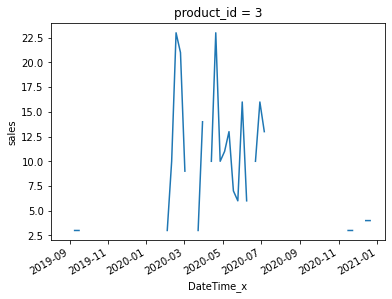

In [ ]:
df_xr.sales[2].plot.line()

In [ ]:
### work on data structure train test split, measure, cross validation

In [ ]:
import numpy as np
import sklearn
from sklearn.model_selection import TimeSeriesSplit
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])
tscv = TimeSeriesSplit()
print(tscv)

for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


TimeSeriesSplit(max_train_size=None, n_splits=5)
TRAIN: [0] TEST: [1]
TRAIN: [0 1] TEST: [2]
TRAIN: [0 1 2] TEST: [3]
TRAIN: [0 1 2 3] TEST: [4]
TRAIN: [0 1 2 3 4] TEST: [5]


In [ ]:
tscv = TimeSeriesSplit(n_splits=3, test_size=2, gap=2)

TypeError: ignored

In [ ]:
for train_index, test_index in tscv.split(X):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]

In [ ]:
X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y = np.array([1, 2, 3, 4, 5, 6])

In [ ]:
X

array([[1, 2],
       [3, 4],
       [1, 2],
       [3, 4],
       [1, 2],
       [3, 4]])

In [ ]:
y

array([1, 2, 3, 4, 5, 6])

In [ ]:
# Fix test_size to 2 with 12 samples
X = np.random.randn(12, 2)
y = np.random.randint(0, 2, 12)
tscv = TimeSeriesSplit(n_splits=3, test_size=2)
for train_index, test_index in tscv.split(X):
   print("TRAIN:", train_index, "TEST:", test_index)
   X_train, X_test = X[train_index], X[test_index]
   y_train, y_test = y[train_index], y[test_index]

In [ ]:
pivoted = full_sales_dataset[["product_id", "DateTime_x", "sales"]].pivot(index = "product_id", columns = "DateTime_x", values = "sales").fillna(0)
pivoted_traffic = full_sales_dataset[["product_id", "DateTime_x", "traffic"]].pivot(index = "product_id", columns = "DateTime_x", values = "traffic").fillna(0)

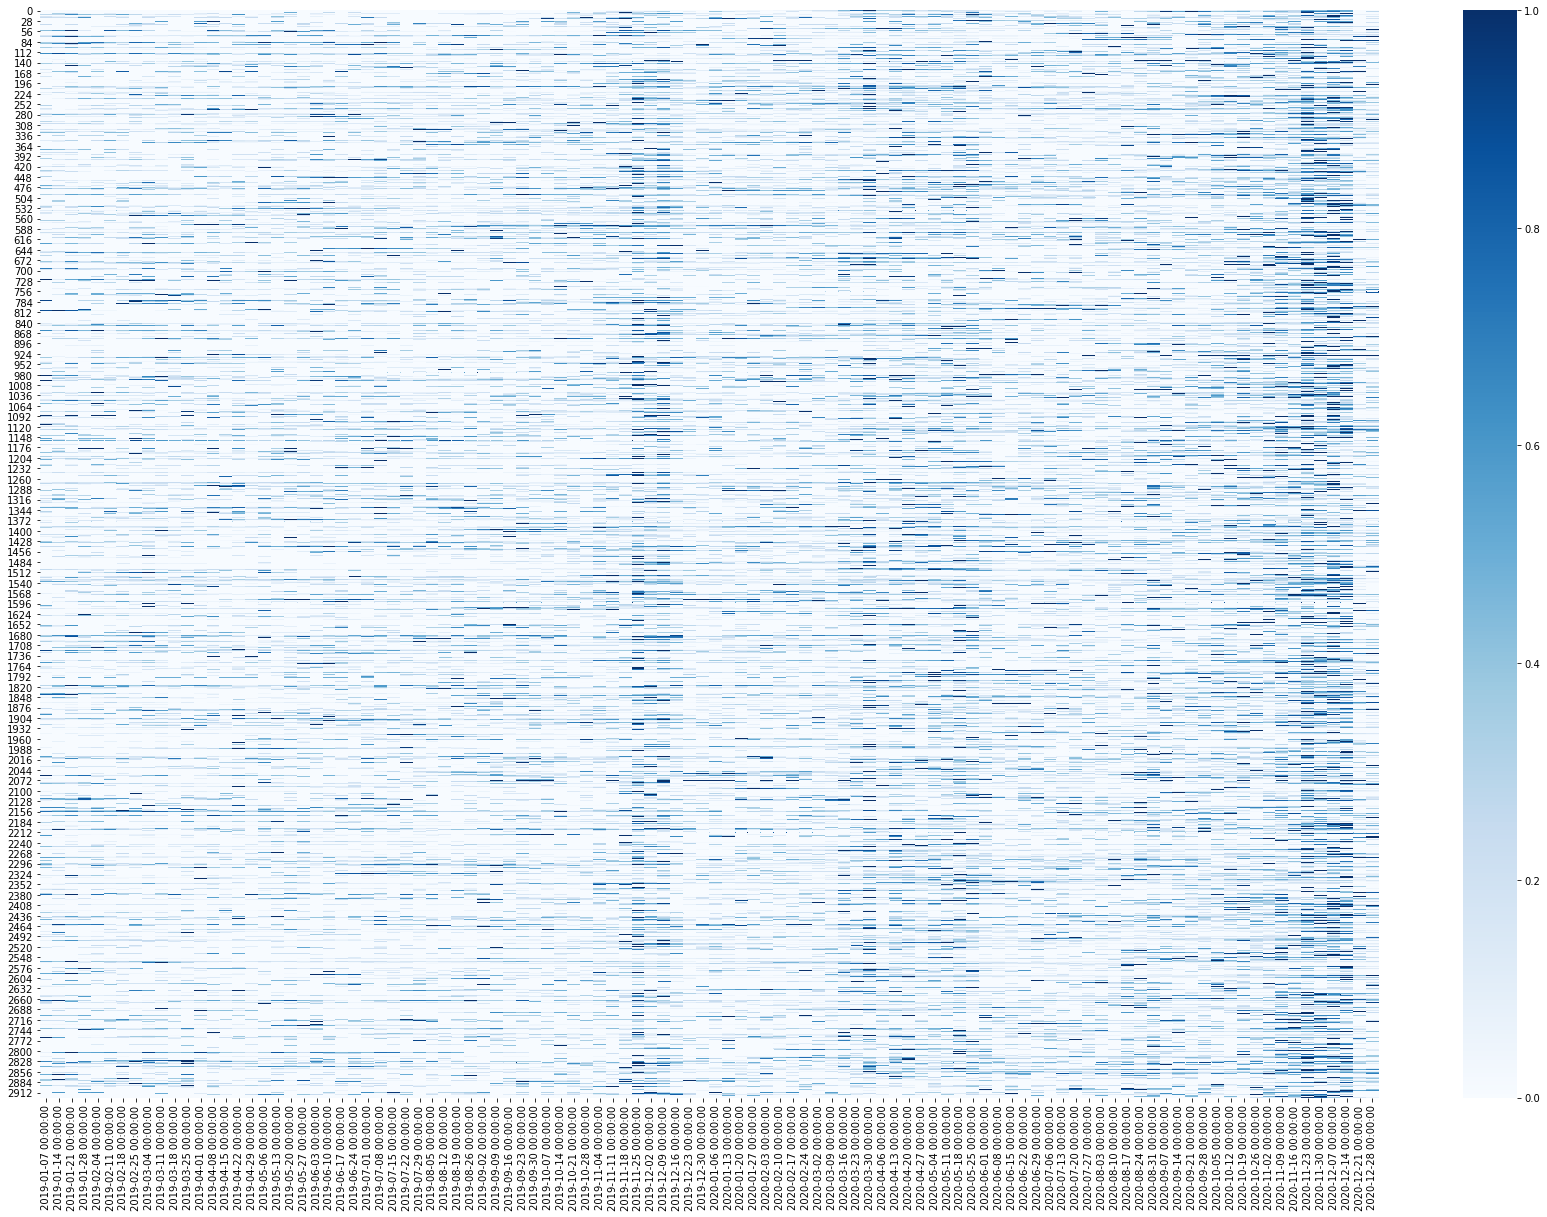

In [ ]:
plt.figure(figsize = (30,20))
sns.heatmap(preprocessing.minmax_scale(pivoted.T).T,  xticklabels=pivoted.columns, cmap = 'Blues')

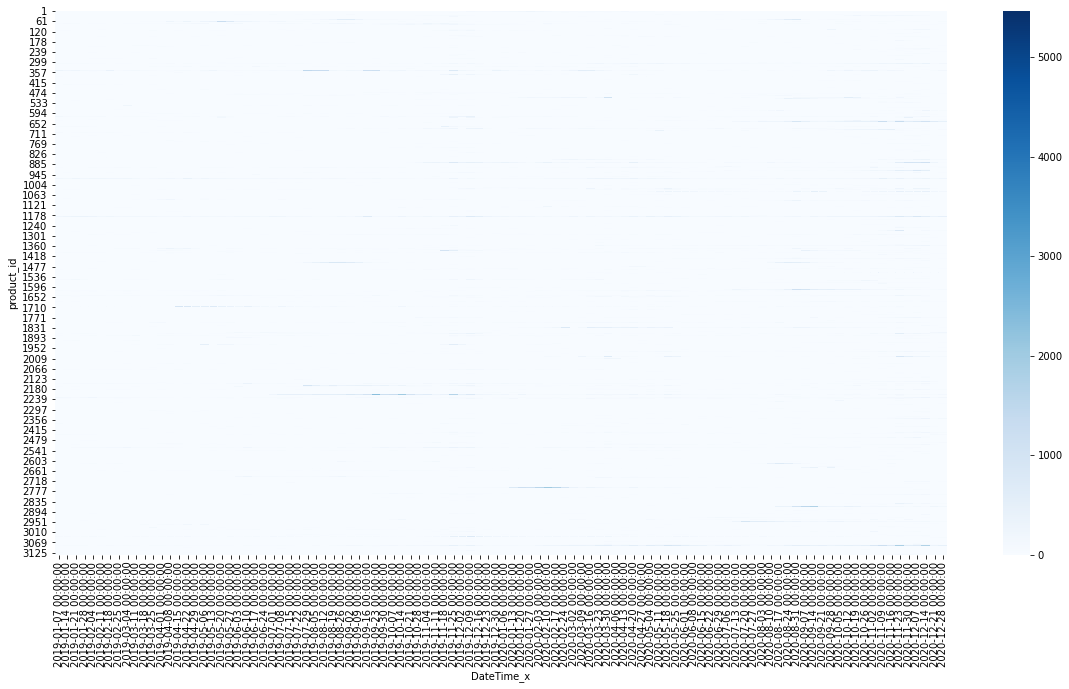

In [ ]:
plt.figure(figsize = (20,10))
sns.heatmap(pivoted,  xticklabels=pivoted.columns, cmap = 'Blues')

In [ ]:
import random

In [ ]:
sample_for_ts = random.sample(list(pivoted.T.columns), 10)

In [ ]:
df = pd.DataFrame([('falcon', 'bird', 389.0, 2),
                   ('parrot', 'bird', 24.0, 2),
                   ('lion', 'mammal', 80.5, 4),
                   ('monkey', 'mammal', np.nan, 4)],
                  columns=['name', 'class', 'max_speed',
                           'num_legs'])

In [ ]:
df

,name,class,max_speed,num_legs
0,falcon,bird,389.0,2
1,parrot,bird,24.0,2
2,lion,mammal,80.5,4
3,monkey,mammal,NaN,4


In [ ]:
df_xr = df.to_xarray()

In [ ]:
df_xr

<xarray.Dataset>
Dimensions:    (index: 4)
Coordinates:
  * index      (index) int64 0 1 2 3
Data variables:
    name       (index) object 'falcon' 'parrot' 'lion' 'monkey'
    class      (index) object 'bird' 'bird' 'mammal' 'mammal'
    max_speed  (index) float64 389.0 24.0 80.5 nan
    num_legs   (index) int64 2 2 4 4

In [ ]:
dates = pd.to_datetime(['2018-01-01', '2018-01-01',
                        '2018-01-02', '2018-01-02'])
df_multiindex = pd.DataFrame({'date': dates,
                              'animal': ['falcon', 'parrot',
                                         'falcon', 'parrot'],
                              'speed': [350, 18, 361, 15],
                              'abc': [1, 2, 3, 4]})
df_multiindex = df_multiindex.set_index(['date', 'animal'])

In [ ]:
full_sales_dataset.set_index(["product_id", "DateTime_x"])

Week_numb  Month  ...  traffic  DateTime_y
product_id DateTime_x                   ...                     
1          2020-07-06        28      7  ...      NaN         NaT
           2020-07-20        30      7  ...      NaN         NaT
           2020-07-27        31      7  ...      1.0  2020-07-27
           2020-08-03        32      8  ...      2.0  2020-08-03
           2020-08-10        33      8  ...      3.0  2020-08-10
...                         ...    ...  ...      ...         ...
3135       2020-11-30        49     11  ...    142.0  2020-11-30
           2020-12-07        50     12  ...     90.0  2020-12-07
           2020-12-14        51     12  ...     85.0  2020-12-14
           2020-12-21        52     12  ...     38.0  2020-12-21
           2020-12-28        53     12  ...     44.0  2020-12-28

[105781 rows x 7 columns]

In [ ]:
full_sales_dataset_indexed = full_sales_dataset.set_index(["product_id", "DateTime_x"])

In [ ]:
full_sales_dataset_indexed

Week_numb  Month  ...  traffic  DateTime_y
product_id DateTime_x                   ...                     
1          2020-07-06        28      7  ...      NaN         NaT
           2020-07-20        30      7  ...      NaN         NaT
           2020-07-27        31      7  ...      1.0  2020-07-27
           2020-08-03        32      8  ...      2.0  2020-08-03
           2020-08-10        33      8  ...      3.0  2020-08-10
...                         ...    ...  ...      ...         ...
3135       2020-11-30        49     11  ...    142.0  2020-11-30
           2020-12-07        50     12  ...     90.0  2020-12-07
           2020-12-14        51     12  ...     85.0  2020-12-14
           2020-12-21        52     12  ...     38.0  2020-12-21
           2020-12-28        53     12  ...     44.0  2020-12-28

[105781 rows x 7 columns]

In [ ]:
full_sales_dataset_indexed_expanded = full_sales_dataset_indexed.groupby(level=0).apply(lambda x: x.reset_index(level=0, drop=True).asfreq("W-Mon").fillna(0))

In [ ]:
original_count = full_sales_dataset_indexed[["sales"]].groupby(level=0).count().rename(columns={'sales':'weeks_original'})

In [ ]:
expanded_count = full_sales_dataset_indexed_expanded[["sales"]].groupby(level=0).count().rename(columns={'sales':'weeks_expanded'})

In [ ]:
result = pd.concat([expanded_count, original_count], axis=1, join="outer").pipe(lambda x: x.assign(nonzero_obs_share = 100*round(x.weeks_original/x.weeks_expanded,4)))

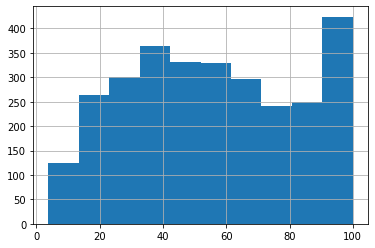

In [ ]:
result.nonzero_obs_share.hist()

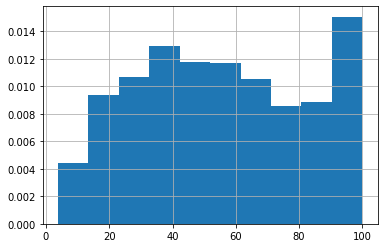

In [ ]:
result.nonzero_obs_share.hist(density = True)

In [ ]:
result.sort_values(by=['nonzero_obs_share'])

,weeks_expanded,weeks_original,nonzero_obs_share
product_id,,,
2537,53,2,3.77
866,76,3,3.95
1636,74,3,4.05
1303,74,3,4.05
1346,89,4,4.49
...,...,...,...
2658,46,46,100.00
1308,35,35,100.00
2894,1,1,100.00


In [ ]:
ex = TimeSeries("DateTime_x" ,full_sales_dataset.loc[full_sales_dataset['product_id'] == 2537])

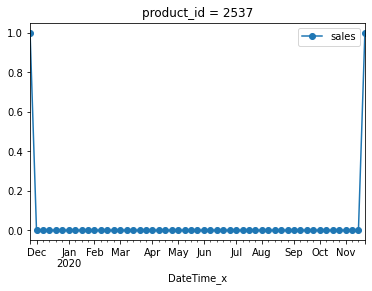

In [ ]:
ex.plot_time_series("sales")

In [ ]:
ex._ts

,product_id,DateTime_x,Week_numb,Month,week_starting_date,sales,category_id,traffic,DateTime_y
DateTime_x,,,,,,,,,
2019-11-25,2537.0,2019-11-25 00:00:00,48,11.0,20191125.0,1.0,5.0,0.0,0
2019-12-02,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0
2019-12-09,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0
2019-12-16,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0
2019-12-23,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0
2019-12-30,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0
2020-01-06,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0
2020-01-13,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0
2020-01-20,0.0,0,0,0.0,0.0,0.0,0.0,0.0,0


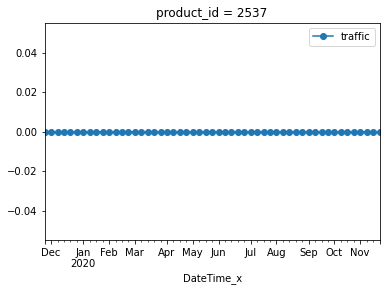

In [ ]:
ex.plot_time_series("traffic")

In [ ]:
full_xarray = full_sales_dataset_indexed_expanded.to_xarray()

In [ ]:
full_xarray.isel(product_id=slice(1,5))

<xarray.Dataset>
Dimensions:             (DateTime_x: 104, product_id: 4)
Coordinates:
  * product_id          (product_id) int64 2 3 4 5
  * DateTime_x          (DateTime_x) datetime64[ns] 2019-01-07 ... 2020-12-28
Data variables:
    Week_numb           (product_id, DateTime_x) object nan nan nan ... 0 '53'
    Month               (product_id, DateTime_x) float64 nan nan ... 0.0 12.0
    week_starting_date  (product_id, DateTime_x) float64 nan nan ... 2.02e+07
    sales               (product_id, DateTime_x) float64 nan nan ... 0.0 25.0
    category_id         (product_id, DateTime_x) float64 nan nan ... 0.0 35.0
    traffic             (product_id, DateTime_x) float64 nan nan ... 0.0 10.0
    DateTime_y          (product_id, DateTime_x) object nan nan ... 0 2020-12-28

In [ ]:
full_xarray

<xarray.Dataset>
Dimensions:             (DateTime_x: 104, product_id: 2926)
Coordinates:
  * product_id          (product_id) int64 1 2 3 4 5 ... 3132 3133 3134 3135
  * DateTime_x          (DateTime_x) datetime64[ns] 2019-01-07 ... 2020-12-28
Data variables:
    Week_numb           (product_id, DateTime_x) object nan nan ... '52' '53'
    Month               (product_id, DateTime_x) float64 nan nan ... 12.0 12.0
    week_starting_date  (product_id, DateTime_x) float64 nan nan ... 2.02e+07
    sales               (product_id, DateTime_x) float64 nan nan ... 17.0 7.0
    category_id         (product_id, DateTime_x) float64 nan nan ... 43.0 43.0
    traffic             (product_id, DateTime_x) float64 nan nan ... 38.0 44.0
    DateTime_y          (product_id, DateTime_x) object nan nan ... 2020-12-28

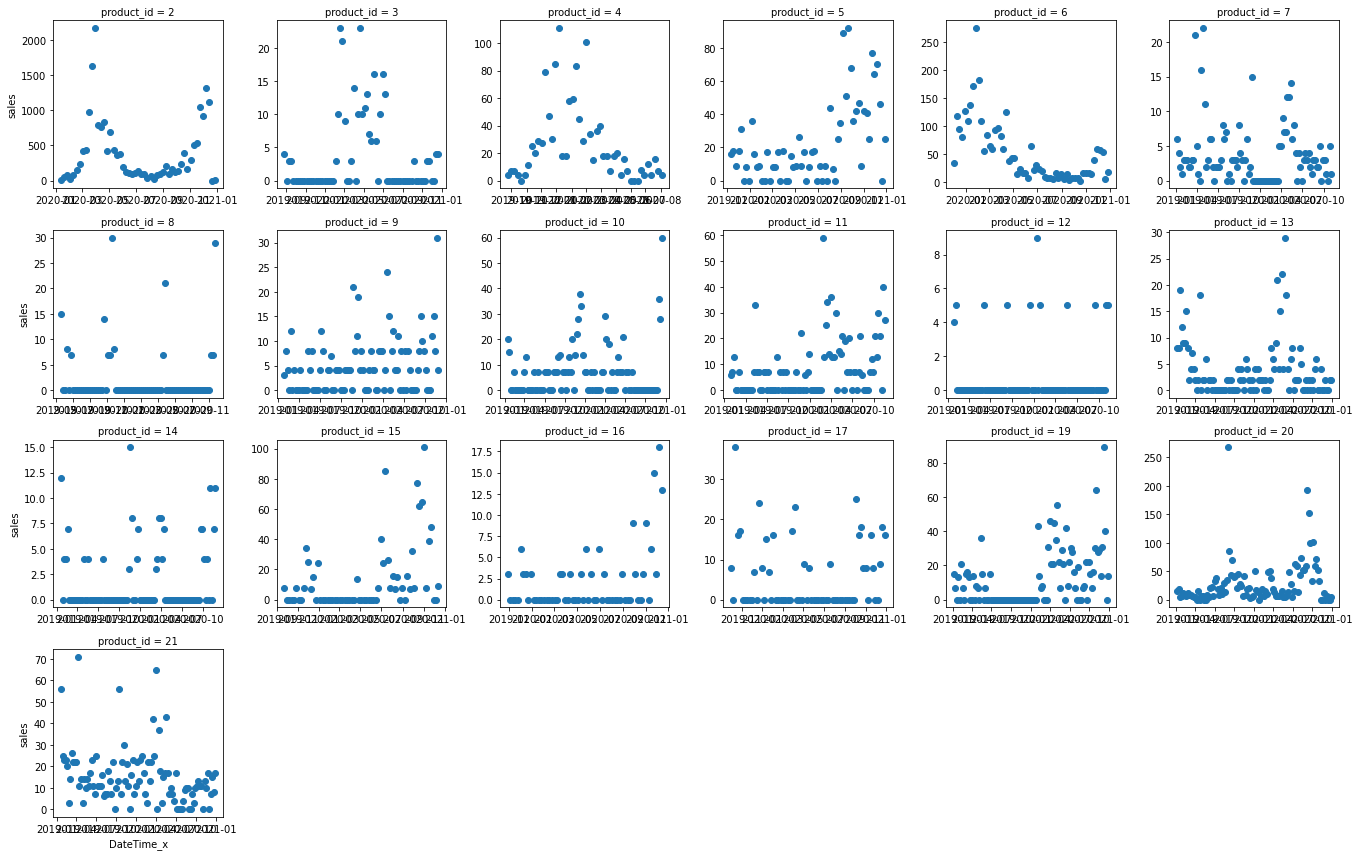

In [ ]:
g_simple = full_xarray.isel(product_id=slice(1,20)).plot.scatter(x="DateTime_x", y="sales", col="product_id", col_wrap=6, sharey = False, sharex = False)

In [ ]:
import statsmodels.api as sm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



SyntaxError: ignored

<AxesSubplot:>

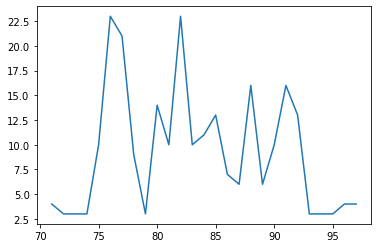

In [ ]:
weekly_sales.loc[weekly_sales.product_id == 3, "sales"].plot()

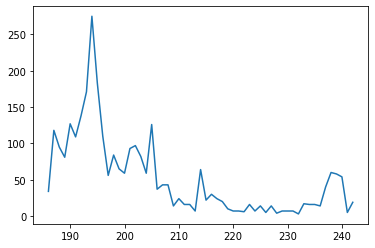

In [ ]:
weekly_sales.loc[weekly_sales.product_id == 6, "sales"].plot()

In [ ]:
weekly_sales.loc[weekly_sales.product_id == 6, "traffic"].plot()

KeyError: ignored

In [ ]:
pivoted_category = full_sales_dataset.loc[full_sales_dataset.category_id ==3, :][["product_id", "DateTime_x", "sales"]].pivot(index = "product_id", columns = "DateTime_x", values = "sales").fillna(0)

<AxesSubplot:>

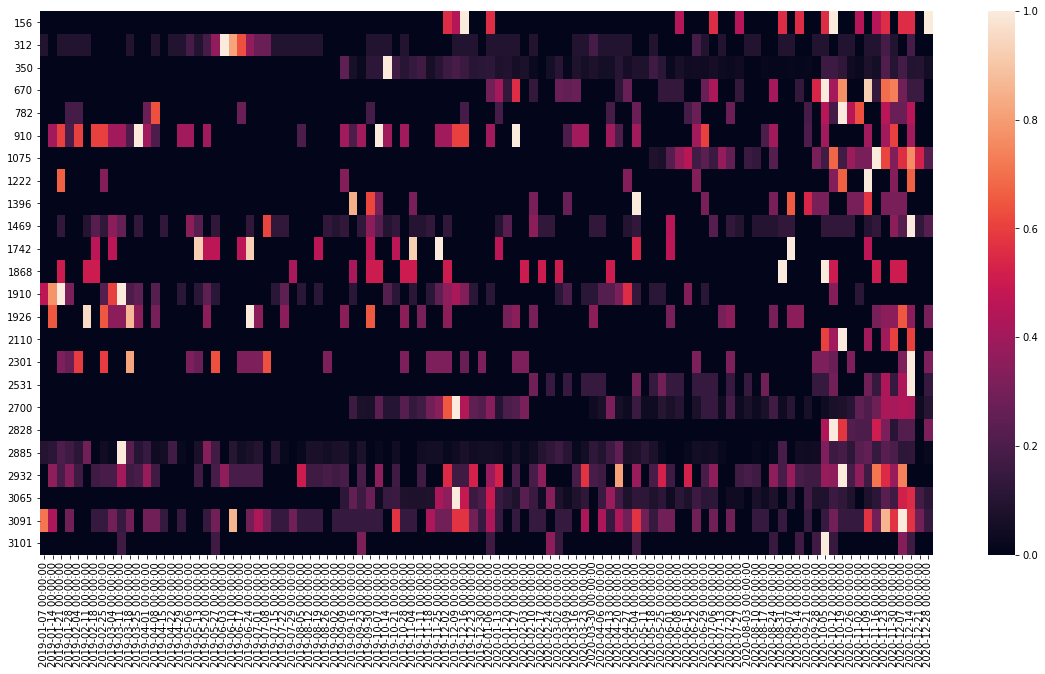

In [ ]:
plt.figure(figsize = (20,10))
sns.heatmap(preprocessing.minmax_scale(pivoted_category.T).T,  xticklabels=pivoted_category.columns, yticklabels=pivoted_category.index)

<AxesSubplot:xlabel='DateTime_x', ylabel='product_id'>

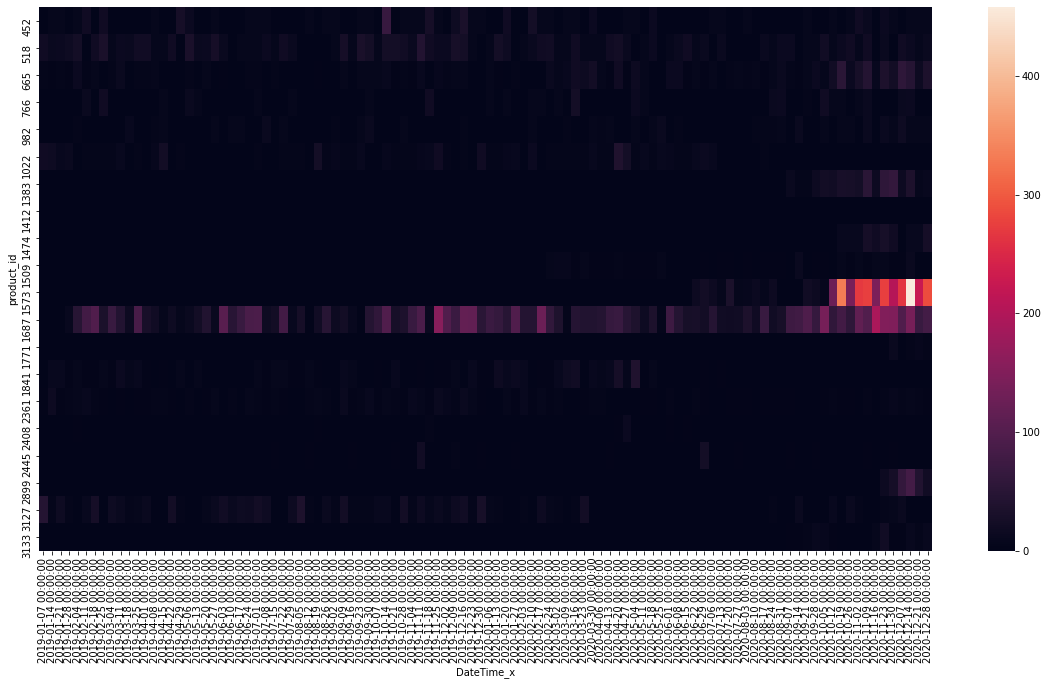

In [ ]:
plt.figure(figsize = (20,10))
sns.heatmap(pivoted_category,  xticklabels=pivoted_category.columns, yticklabels=pivoted_category.index)